In [134]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as v2
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torchmetrics

In [135]:
seed = 42
torch.random.manual_seed(seed)

device = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

batch_size = 64
lr = 1e-3
epochs = 10

root_path = "/Users/asandeistefan/Downloads/apoai2025-cv"

# Data preparation

In [136]:
dataset = ImageFolder(f'{root_path}', transform=v2.Compose([
    v2.Resize((32, 32)),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,))
]))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/opt/homebrew/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Model

In [137]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(in_features=16 * 6 * 6, out_features=64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))

        x = x.view(-1, 16 * 6 * 6)
        x = F.leaky_relu(self.fc1(x))

        x = self.fc2(x)
        x = F.sigmoid(x)

        return x

In [138]:
model = MyModel().to(device)

In [139]:
x = next(iter(train_dataloader))[0].to(device)
model(x).shape

torch.Size([64, 1])

# Training

In [140]:
losses = []
accuracy = torchmetrics.Accuracy(task='binary').to(device)

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
critetion = nn.BCELoss()

In [141]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    accuracy.reset()

    for batch in tqdm(train_dataloader):
        images, labels = batch[0].to(device), batch[1].unsqueeze(-1).float().to(device)

        # forward pass
        preds = model(images)
        loss = critetion(preds, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # stats
        running_loss += loss.item()
        losses.append(loss.item())
    scheduler.step()

    model.eval()
    for batch in tqdm(test_dataloader):
        images, labels = batch[0].to(device), batch[1].unsqueeze(-1).float().to(device)
        with torch.no_grad():
            preds = model(images)
            accuracy(preds, labels)

    print(f"Epoch {epoch}, loss={(running_loss/len(train_dataloader)):.2f}, accuracy={accuracy.compute()*100:.1f}%")

100%|██████████| 32/32 [00:01<00:00, 27.14it/s]


Epoch 0, loss=0.60, accuracy=70.7%


100%|██████████| 32/32 [00:00<00:00, 34.29it/s]


Epoch 1, loss=0.56, accuracy=70.2%


100%|██████████| 32/32 [00:00<00:00, 39.30it/s]


Epoch 2, loss=0.54, accuracy=71.7%


100%|██████████| 32/32 [00:00<00:00, 40.22it/s]


Epoch 3, loss=0.53, accuracy=71.8%


100%|██████████| 32/32 [00:00<00:00, 39.03it/s]


Epoch 4, loss=0.53, accuracy=72.1%


100%|██████████| 32/32 [00:00<00:00, 39.36it/s]


Epoch 5, loss=0.52, accuracy=72.1%


100%|██████████| 32/32 [00:00<00:00, 39.28it/s]


Epoch 6, loss=0.51, accuracy=72.6%


100%|██████████| 32/32 [00:00<00:00, 39.77it/s]


Epoch 7, loss=0.51, accuracy=72.8%


100%|██████████| 32/32 [00:00<00:00, 39.71it/s]


Epoch 8, loss=0.50, accuracy=72.6%


100%|██████████| 32/32 [00:00<00:00, 39.36it/s]

Epoch 9, loss=0.50, accuracy=72.9%


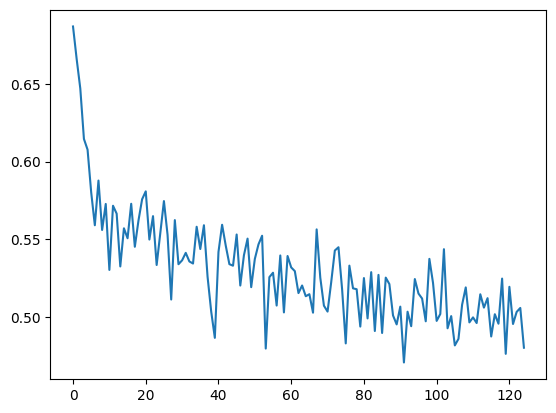

In [142]:
plt.plot(torch.tensor(losses).reshape(125, -1).mean(dim=1).cpu().detach())

# Submission

In [143]:
# 1. Save the weights
WEIGHTS_FILE = "submission_dic.pth"
torch.save(model.state_dict(), WEIGHTS_FILE)

# 2. Write out the submission script
SUBMISSION_SCRIPT = Path("submission_model.py")
SUBMISSION_SCRIPT.write_text(
    """
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(in_features=32 * 6 * 6, out_features=1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))

        x = x.view(-1, 32 * 6 * 6)
        x = self.fc1(x)

        x = F.sigmoid(x)
        return x
""".lstrip()
)

# 3. Zip them up
ZIP_NAME = "submission.zip"
with zipfile.ZipFile(ZIP_NAME, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(WEIGHTS_FILE)
    z.write(SUBMISSION_SCRIPT)

print(f"Created {ZIP_NAME} containing:")
print(" ", WEIGHTS_FILE, "\n ", SUBMISSION_SCRIPT.name)

Created submission.zip containing:
  submission_dic.pth 
  submission_model.py
